# Baseline #0: Identity

In [6]:
from src.util import seed_everything, update_avg, cleanup
from src.config import SEED, INTERIM_DATA_DIR

In [7]:
import os

if not INTERIM_DATA_DIR.exists():
    os.chdir("..")

In [8]:
import logging

logging.basicConfig(level=logging.ERROR)

In [9]:
seed_everything(SEED)

In [10]:
import pandas as pd

from src.data.dataset import create_loaders

In [8]:
BATCH_SIZE = 512

In [6]:
train_loader, val_loader, test_loader = create_loaders(
    pd.read_csv(INTERIM_DATA_DIR / "swapped.csv"), batch_size=BATCH_SIZE
)

In [11]:
from src.models.identity import IdentityModel
from src.metrics import calculate_all

In [8]:
model = IdentityModel()

In [11]:
from tqdm import tqdm

avg_non_tox = 0
avg_bert = 0
avg_bleu = 0
for i, batch in (pbar := tqdm(enumerate(test_loader), total=len(test_loader))):
    inputs, target = batch
    test_pred = model.predict(inputs)
    non_tox, bert, bleu = calculate_all(inputs, test_pred, target)
    avg_non_tox = update_avg(avg_non_tox, non_tox, i)
    avg_bert = update_avg(avg_bert, bert, i)
    avg_bleu = update_avg(avg_bleu, bleu, i)
    pbar.set_description(f"{avg_non_tox=:.3f} {avg_bert=:.3f} {avg_bleu=:.3f}")

avg_non_tox=0.129 avg_bert=1.000 avg_bleu=0.173: 100%|██████████| 57/57 [07:57<00:00,  8.38s/it]


Non-toxicity and BLEU scores are quite poor, but at least we achieved the best similarity with this model :-)

In [12]:
cleanup()

# Baseline #1: Profanity filter

In [12]:
from src.models.profanity_filter import ProfanityFilter

In [13]:
model = ProfanityFilter(INTERIM_DATA_DIR / "bad_words.txt")

In [14]:
BATCH_SIZE = 256

In [15]:
train_loader, val_loader, test_loader = create_loaders(
    pd.read_csv(INTERIM_DATA_DIR / "swapped.csv"), batch_size=BATCH_SIZE
)

In [16]:
from tqdm import tqdm

avg_non_tox = 0
avg_bert = 0
avg_bleu = 0
for i, batch in (pbar := tqdm(enumerate(test_loader), total=len(test_loader))):
    inputs, target = batch
    train_pred = model.predict(inputs)
    non_tox, bert, bleu = calculate_all(inputs, train_pred, target)
    avg_non_tox = update_avg(avg_non_tox, non_tox, i)
    avg_bert = update_avg(avg_bert, bert, i)
    avg_bleu = update_avg(avg_bleu, bleu, i)
    pbar.set_description(f"{avg_non_tox=:.3f} {avg_bert=:.3f} {avg_bleu=:.3f}")

  0%|          | 0/113 [00:00<?, ?it/s]Some weights of the model checkpoint at SkolkovoInstitute/roberta_toxicity_classifier_v1 were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
avg_non_tox=0.507 avg_bert=0.456 avg_bleu=0.102: 100%|██████████| 113/113 [09:42<00:00,  5.16s/it]


## Visualize word cloud for predicted sentences

In [17]:
from src.visualization.make_wordcloud import make_wordcloud

all_preds = pd.Series(model.predict(sum([batch[0] for batch in tqdm(test_loader)], [])))

100%|██████████| 113/113 [00:06<00:00, 17.83it/s]


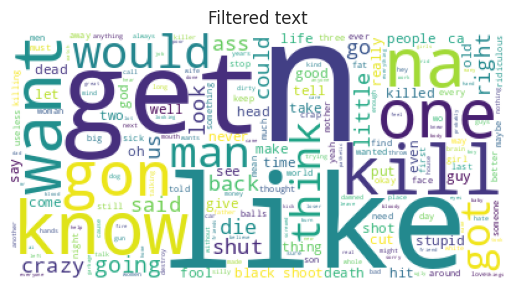

In [20]:
import matplotlib.pyplot as plt

plt.title("Filtered text")
plt.axis("off")
plt.imshow(make_wordcloud(all_preds))
plt.show()